# Notebook Processo Seletivo Aluno Especial IA-024 1S2024 FEEC-UNICAMP

Candidato: Leandro Carísio Fernandes

versão 5 de fevereiro de 2024, 19h

In [1]:
!pip install torchtext
!pip install 'portalocker>=2.0.0'

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.datasets import IMDB
from collections import Counter
import torch.nn as nn
import torch.optim as optim

## I - Vocabulário e Tokenização

In [3]:
## Função gerada com ajuda do ChatGPT
import re

def tokenizar(frase):
    # return frase.split() # Usar esse return para uma tokenização simples (apenas split)
    # Converter a frase para minúsculo
    frase = frase.lower()
    # Remover caracteres especiais e pontuação usando expressões regulares
    frase = re.sub(r'[^\w\s]', '', frase)
    # Dividir a frase em palavras
    palavras = frase.split()
    return palavras

# Exemplo de uso
frase = "Olá! Como você está? Eu estou bem, obrigado."
palavras = tokenizar(frase)
print(palavras)

['olá', 'como', 'você', 'está', 'eu', 'estou', 'bem', 'obrigado']


In [4]:
# O dataset torchtext.datasets.IMDB classifica os sentimentos negativos e positivos como 1 e 2
neg = 1
pos = 2

In [5]:
%%time
# limit the vocabulary size to 20000 most frequent tokens
vocab_size = 20000

imdb_train = list(IMDB(split='train'))
# Para testar com uma amostra menor (por exemplo, 200 elementos)
#idx_amostras = list(range(200))
#idx_amostras = list(range(100)) + list(range(24900, 25000))
#vocab_size = 10000
# Para testar com toda a base:
idx_amostras = list(range(len(imdb_train)))
vocab_size = 20000

counter = Counter()
# counter para calcular o total de amostras positivas e negativas
counter_sentiment = Counter()
for (label, line) in [imdb_train[i] for i in idx_amostras]:
    # Com tokenizador:
    counter.update(tokenizar(line))
    # counter.update(line.split())
    # faz o update do contador de amostras positivas/negativas
    counter_sentiment.update([label])
# termina de calcular o tamanho médio das amostras
avg_words_per_sample = sum(counter.values())/sum(counter_sentiment.values())

# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)} # words indexed from 1 to 20000

CPU times: user 15.3 s, sys: 621 ms, total: 15.9 s
Wall time: 36.9 s


In [6]:
print('Número de amostras positivas: ', counter_sentiment[pos])
print('Número de amostras negativas: ', counter_sentiment[neg])
print('Total de amostras: ', sum(counter_sentiment.values()))
print('Média de palavra por amostra: ', avg_words_per_sample)

Número de amostras positivas:  12500
Número de amostras negativas:  12500
Total de amostras:  25000
Média de palavra por amostra:  232.81272


In [7]:
# As cinco palavras mais e menos frequentes são:
print('Cinco palavras mais frequentes:', most_frequent_words[0:5])
print('Cinco palavras menos frequentes:', most_frequent_words[-5:])

Cinco palavras mais frequentes: ['the', 'and', 'a', 'of', 'to']
Cinco palavras menos frequentes: ['dolores', 'showings', 'cacoyannis', 'goring', 'gorris']


In [8]:
def encode_sentence(sentence, vocab):
    return [vocab.get(word, 0) for word in tokenizar(sentence)] # 0 for OOV
    # Código original
    # return [vocab.get(word, 0) for word in sentence.split()] # 0 for OOV

encode_sentence("I like Pizza", vocab)

[9, 38, 7923]

In [9]:
# Codificação de uma palavra que não está no vocabulário:
print(encode_sentence("alskfjlaksjflasfjlaskfjlas", vocab))

[0]


In [10]:
# Número de unknown tokens no conjunto de treinamento:
# Calcula as palavras únicas e subtrai do tamanho do vocabulário
print('Total de palavras distintas classificadas como UNK', len(counter.keys()) - 20000)

# Separando quais os tokens e contando novamente:
unk_tokens = sorted(counter, key=counter.get, reverse=True)[vocab_size:]
print('Total de palavras distintas classificadas como UNK', len(unk_tokens))

# Total de palavras classificadas como UNK na base de treinamento
total_unk = sum([counter[unk] for unk in unk_tokens])
print('Total de palavras classificadas como UNK', total_unk)

Total de palavras distintas classificadas como UNK 101045
Total de palavras distintas classificadas como UNK 101045
Total de palavras classificadas como UNK 214060


## II - Dataset

In [11]:
%%time

from torch.nn.functional import one_hot
# Dataset Class with One-hot Encoding
class IMDBDataset(Dataset):
    def __init__(self, split, vocab):
        self.data = list(IMDB(split=split))
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, line = self.data[idx]
        label = 1 if label == 1 else 0

        # one-hot encoding
        X = torch.zeros(len(self.vocab) + 1)
        #for word in encode_sentence(line, self.vocab):
        #    X[word] = 1
        # Otimizando o one-hot encoding
        X[encode_sentence(line, self.vocab)] = 1

        return X, torch.tensor(label)


# Load Data with One-hot Encoding
train_data = IMDBDataset('train', vocab)
test_data = IMDBDataset('test', vocab)


CPU times: user 13.3 s, sys: 305 ms, total: 13.6 s
Wall time: 13.6 s


In [12]:
# Trecho de código para assegurar que o refactoring está correto
sentence = "Some sentence to check if the refactoring is correct. Let's just use some random words now: the is a blue color"
X = torch.zeros(len(vocab) + 1)
for word in encode_sentence(line, vocab):
    X[word] = 1
Y = torch.zeros(len(vocab) + 1)
Y[encode_sentence(line, vocab)] = 1
sum(abs(X-Y))

tensor(0.)

In [13]:
# Se antes o sentimento era calculado como 1 (negativo) e 2 (positivo), agora ele passou a calcular como 1 (negativo) e 0 (positivo)
# Assim, vamos ajustar as variavéis pos e neg:
neg = 1
pos = 0

# Faça um código que aplique um laço sobre o dataset train_data e calcule novamente quantas amostras positivas e negativas do dataset.
counter_sentiment = Counter()
sum_one_hot_tensor = torch.zeros(vocab_size + 1)
for one_hot_tensor, label in train_data:
  counter_sentiment.update([label.item()])
  sum_one_hot_tensor += one_hot_tensor

avg_words_per_sample = sum(sum_one_hot_tensor)/sum(counter_sentiment.values())

print('Número de amostras positivas: ', counter_sentiment[pos])
print('Número de amostras negativas: ', counter_sentiment[neg])
print('Total de amostras: ', sum(counter_sentiment.values()))
print('Média de palavra por amostra: ', avg_words_per_sample)

Número de amostras positivas:  12500
Número de amostras negativas:  12500
Total de amostras:  25000
Média de palavra por amostra:  tensor(133.7259)


## III - Data Loader

In [14]:
%%time
batch_size = 128
# define dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

CPU times: user 559 µs, sys: 0 ns, total: 559 µs
Wall time: 567 µs


In [15]:
# Número de amostras de test_loader
print(len(test_data))
print(len(test_loader))

25000
196


Calculando o total de iterações para percorrer todo o train_loader:

In [16]:
#%%time
# Calculando o total de iterações para percorrer todo o train_loader:
#total_amostras_batch = 0
#for iteracao, batch in enumerate(train_loader, 1):
#    total_amostras_batch = len(batch[1])
#    pass
#
#print(iteracao)
#print(total_amostras_batch)

Calculando a relação R usando list comprehension:

In [17]:
# Calculando a relação R usando list comprehension
#R = [sum(batch[1])/len(batch[1]) for batch in train_loader]
#print(sum(R)/len(R))

Estrutura de um batch:

In [18]:
#batch = next(iter(train_loader))
#print(f"O batch possui {len(batch)} elementos")
#print(f"O primeiro elemento são os dados de entrada. Possui shape {batch[0].shape}")
#print(f"Ou seja, são {batch[0].shape[0]} linhas (tamanho do batch) e {batch[0].shape[1]} colunas (tamanho do vocabulário com UNK)")
#print(f"O tipo de dado do input é {batch[0].dtype}")
#print(f"O segundo elemento são os labels relacionados. Possui shape {batch[1].shape} (tamanho do batch)")
#print(f"O tipo de dado do label é {batch[1].dtype}")

## IV - Modelo

In [19]:
class OneHotMLP(nn.Module):
    def __init__(self, vocab_size, n_logitos = 1):
        super(OneHotMLP, self).__init__()

        self.fc1 = nn.Linear(vocab_size+1, 200)
        self.fc2 = nn.Linear(200, n_logitos)

        self.relu = nn.ReLU()

    def forward(self, x):
        o = self.fc1(x.float())
        o = self.relu(o)
        return self.fc2(o)

# Model instantiation
model = OneHotMLP(vocab_size, 2)

## V - Laço de Treinamento - Otimização da função de Perda pelo Gradiente descendente

In [20]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('using CPU')

GPU: Tesla T4


In [21]:
# Loop de teste alterado para medir apeas o tempo de
#import time

# Training loop
#num_epochs = 5
#for epoch in range(num_epochs):
#    start_time = time.time()  # Start time of the epoch
#    for inputs, labels in train_loader:
#        teste = 1
#
#    end_time = time.time()  # End time of the epoch
#    epoch_duration = end_time - start_time  # Duration of epoch
#
#    print(f'Epoch [{epoch+1}/{num_epochs}], \
#            Elapsed Time: {epoch_duration:.2f} sec')

In [22]:
import math

# Gerado com ajuda do chatGPT
def calcula_loss_e_perplexidade(model, criterion, n_logitos, loader):
  with torch.no_grad():  # Garante que nenhum gradiente seja calculado
    model.eval()  # Coloca o modelo no modo de avaliação (não treinamento)
    total_loss = 0.0
    total_samples = 0
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        # Calcula a perda
        if n_logitos == 1:
            #Para usar com nn.BCEWithLogitsLoss():
            loss = criterion(outputs.squeeze().to(device), labels.float()).to(device)
        else:
            # Para usar com nn.CrossEntropyLoss():
            loss = criterion(nn.functional.softmax(outputs, dim=1), labels)
        # Acumula a perda e o número total de amostras
        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

  loss = total_loss / total_samples
  ppl = math.exp(loss)
  return loss, ppl

In [23]:
import time

def train_model(model, lr=0.001, num_epochs=5, n_logitos = 1):
    model = model.to(device)
    # Define loss and optimizer
    if n_logitos == 1:
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    loss_por_epoca = []

    loss_ppl_treinamento_por_epoca = []
    loss_ppl_teste_por_epoca = []

    print(f'Loss e perplexidade antes de iniciar o treinamento: {calcula_loss_e_perplexidade(model, criterion, n_logitos, train_loader)}')
    # Training loop
    for epoch in range(num_epochs):
        start_time = time.time()  # Start time of the epoch
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(inputs)
            if n_logitos == 1:
                # Para usar com nn.BCEWithLogitsLoss():
                loss = criterion(outputs.squeeze(), labels.float())
            else:
                # Para usar com nn.CrossEntropyLoss():
                loss = criterion(nn.functional.softmax(outputs, dim=1), labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        end_time = time.time()  # End time of the epoch
        epoch_duration = end_time - start_time  # Duration of epoch

        print(f'Epoch [{epoch+1}/{num_epochs}], \
                Loss: {loss.item():.4f}, \
                Elapsed Time: {epoch_duration:.2f} sec')
        loss_por_epoca.append(loss.item())

        loss_ppl_treinamento_epoca_i = calcula_loss_e_perplexidade(model, criterion, n_logitos, train_loader)
        loss_ppl_treinamento_por_epoca.append(loss_ppl_treinamento_epoca_i)
        print(f'Loss e perplexidade treinamento: {loss_ppl_treinamento_epoca_i}')

        loss_ppl_teste_epoca_i = calcula_loss_e_perplexidade(model, criterion, n_logitos, test_loader)
        loss_ppl_teste_por_epoca.append(loss_ppl_teste_epoca_i)
        print(f'Loss e perplexidade teste: {loss_ppl_teste_epoca_i}')

    return loss_ppl_treinamento_por_epoca, loss_ppl_teste_por_epoca

n_logitos = 1
model = OneHotMLP(vocab_size, n_logitos)
loss_ppl_treinamento_por_epoca, loss_ppl_teste_por_epoca = train_model(model, lr=0.1, num_epochs=15, n_logitos=n_logitos)

Loss e perplexidade antes de iniciar o treinamento: (0.6932015802764893, 2.0001088023924707)
Epoch [1/15],                 Loss: 0.3590,                 Elapsed Time: 6.52 sec
Loss e perplexidade treinamento: (0.37721463454246523, 1.4582172595793867)
Loss e perplexidade teste: (0.39817551761627196, 1.4891053711967368)
Epoch [2/15],                 Loss: 0.2976,                 Elapsed Time: 5.30 sec
Loss e perplexidade treinamento: (0.27799754282951356, 1.3204829525533701)
Loss e perplexidade teste: (0.3176313918209076, 1.3738697482546698)
Epoch [3/15],                 Loss: 0.3121,                 Elapsed Time: 6.13 sec
Loss e perplexidade treinamento: (0.3579982614803314, 1.4304631335894433)
Loss e perplexidade teste: (0.4253342184638977, 1.5301017224624898)
Epoch [4/15],                 Loss: 0.2671,                 Elapsed Time: 6.38 sec
Loss e perplexidade treinamento: (0.376180210814476, 1.456709624946468)
Loss e perplexidade teste: (0.4682546864700317, 1.5972041371735854)
Epoch 

Exibe gráficos de perplexidade e loss para mostrar overfitting (tem que fazer o cálculo com muitas épocas para mostrar isso):

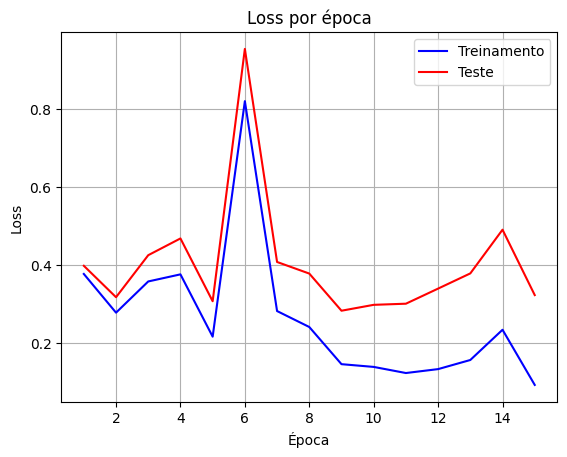

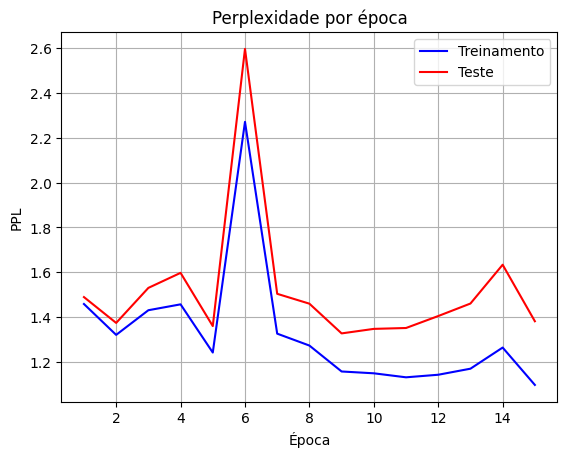

In [24]:
import matplotlib.pyplot as plt

def plotar_dois_graficos(x, y1, y2, titulo, label1, label2, cor1='blue', cor2='red', xlabel='X', ylabel='Y', grid=True):
    # Configurações do primeiro gráfico
    plt.figure()
    plt.plot(x, y1, color=cor1, label=label1)

    # Configurações do segundo gráfico
    plt.plot(x, y2, color=cor2, label=label2)

    # Adicionando título e legendas
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    # Adicionando grid se necessário
    if grid:
        plt.grid(True)

    # Exibindo o gráfico
    plt.show()

epocas = range(1, len(loss_ppl_treinamento_por_epoca)+1)
loss_treinamento, ppl_treinamento = zip(*loss_ppl_treinamento_por_epoca)
loss_teste, ppl_teste = zip(*loss_ppl_teste_por_epoca)

plotar_dois_graficos(epocas, loss_treinamento, loss_teste, titulo='Loss por época', label1='Treinamento', label2='Teste', xlabel='Época', ylabel='Loss')
plotar_dois_graficos(epocas, ppl_treinamento, ppl_teste, titulo='Perplexidade por época', label1='Treinamento', label2='Teste', xlabel='Época', ylabel='PPL')


## VI - Avaliação

In [25]:
## evaluation

def eval_model(model, n_logitos):
  model.eval()

  with torch.no_grad():
      correct = 0
      total = 0
      for inputs, labels in test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          if n_logitos == 1:
              # Para usar com nn.BCEWithLogitsLoss():
              # predicted = torch.round(torch.sigmoid(outputs.squeeze()))
              # Podemos calcular isso de forma mais simples assim:
              predicted = (outputs.squeeze() >= 0).int()
          else:
              # Para usar com nn.CrossEntropyLoss():
              probabilities = nn.functional.softmax(outputs, dim=1)
              _, predicted = torch.max(probabilities, 1)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print(f'Test Accuracy: {100 * correct / total}%')

      # Alterações para calcular a loss e a perplexidade:
      if n_logitos == 1:
          criterion = nn.BCEWithLogitsLoss()
      else:
          criterion = nn.CrossEntropyLoss()
      loss, ppl = calcula_loss_e_perplexidade(model, criterion, n_logitos, test_loader)
      print(f'Loss: {loss}')
      print(f'Perplexidade: {ppl}')
      return 100 * correct / total, loss, ppl

eval_model(model, n_logitos)

Test Accuracy: 87.9%
Loss: 0.32305172422409056
Perplexidade: 1.3813367976319162


(87.9, 0.32305172422409056, 1.3813367976319162)

# Avaliando algumas learning rates

In [40]:
%%time
lrs_para_avaliar = [0.1, 0.01, 0.001, 0.0001]

resultado_por_lr = {}
num_epoch = 15
n_logitos = 1

for lr in lrs_para_avaliar:
    # Cria um modelo
    model = OneHotMLP(vocab_size, n_logitos)
    print(f'Treinando modelo com lr={lr}')
    loss_ppl_treinamento_por_epoca, _ = train_model(model, lr, num_epoch)
    acc = eval_model(model, n_logitos)
    resultado_por_lr[lr] = {'loss_ppl_por_epoca': loss_ppl_treinamento_por_epoca, 'acc': acc}

Treinando modelo com lr=0.1
Loss e perplexidade antes de iniciar o treinamento: (0.6938112104225159, 2.001328500758414)
Epoch [1/15],                 Loss: 0.5831,                 Elapsed Time: 5.74 sec
Loss e perplexidade treinamento: (0.3551149643611908, 1.4263446236544788)
Loss e perplexidade teste: (0.3737567927074432, 1.453183682606581)
Epoch [2/15],                 Loss: 0.2209,                 Elapsed Time: 6.34 sec
Loss e perplexidade treinamento: (0.2731620704269409, 1.3141132064553007)
Loss e perplexidade teste: (0.31329715197563174, 1.3679279531338444)
Epoch [3/15],                 Loss: 0.2279,                 Elapsed Time: 5.43 sec
Loss e perplexidade treinamento: (0.2393679766845703, 1.270445945067642)
Loss e perplexidade teste: (0.29918426080703736, 1.3487581238381652)
Epoch [4/15],                 Loss: 0.1981,                 Elapsed Time: 6.44 sec
Loss e perplexidade treinamento: (0.23650830194473266, 1.2668180726301035)
Loss e perplexidade teste: (0.31215756980896, 1

Mostra a loss em função da LR:

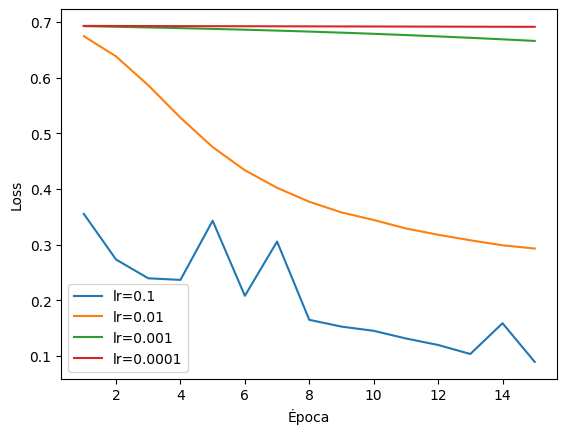

In [41]:
import matplotlib.pyplot as plt

plt.figure()

# Plota loss
for lr in lrs_para_avaliar:
    loss_por_epoca, ppl_por_epoca = zip(*resultado_por_lr[lr]['loss_ppl_por_epoca'])
    plt.plot(range(1, num_epoch+1), loss_por_epoca, label=f'lr={lr}')
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend()

Mostra a accuracy por LR no final do treinamento:

In [43]:
resultado_por_lr[lr]['acc']

(54.628, 0.6916012260818482, 1.9969104797879322)

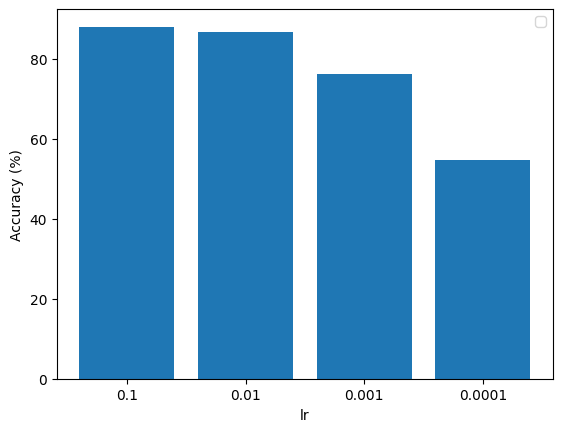

In [44]:
import matplotlib.pyplot as plt

plt.figure()

plt.bar([str(lr) for lr in lrs_para_avaliar], [resultado_por_lr[lr]['acc'][0] for lr in lrs_para_avaliar])
plt.xlabel('lr')
plt.ylabel('Accuracy (%)')
plt.legend()

# Exeperimentando o modelo

In [45]:
# Testes para experimentar o modelo
# Pega um batch qualquer
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
input, target = next(iter(train_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OneHotMLP(vocab_size)
model.to(device)

# Calcula os logitos
logit = model(input.to(device))
## Converte para probabilidade
prob = torch.sigmoid(logit)
print(f"A média do cálculo da probabilidade da saída é {sum(prob)/len(prob)}")

target_estimado = torch.round(prob).squeeze()
num_acertos = ((target_estimado - target.to(device)) == 0).sum().item()

print(f"Número de acertos: {num_acertos}")
print(f"Tamanho do batch: {len(target)}")
print(f"Acerto médio: {num_acertos/len(target)}")

# Após treinar o modelo
train_model(model, lr=0.1, num_epochs=5)
logit = model(input.to(device))
prob = torch.sigmoid(logit)
print(f"A média do cálculo da probabilidade da saída é {sum(prob)/len(prob)}")

target_estimado = torch.round(prob).squeeze()
num_acertos = ((target_estimado - target.to(device)) == 0).sum().item()

print(f"Número de acertos: {num_acertos}")
print(f"Tamanho do batch: {len(target)}")
print(f"Acerto médio: {num_acertos/len(target)}")

A média do cálculo da probabilidade da saída é tensor([0.5060], device='cuda:0', grad_fn=<DivBackward0>)
Número de acertos: 64
Tamanho do batch: 128
Acerto médio: 0.5
Loss e perplexidade antes de iniciar o treinamento: (0.6930578614616394, 1.999821369781052)
Epoch [1/5],                 Loss: 0.3289,                 Elapsed Time: 5.43 sec
Loss e perplexidade treinamento: (0.36159351042747495, 1.4356152607045825)
Loss e perplexidade teste: (0.37958968179702757, 1.4616847105282873)
Epoch [2/5],                 Loss: 0.2660,                 Elapsed Time: 6.14 sec
Loss e perplexidade treinamento: (0.28252290011405945, 1.326472151112498)
Loss e perplexidade teste: (0.32156712976455687, 1.3792875941698288)
Epoch [3/5],                 Loss: 0.2942,                 Elapsed Time: 5.40 sec
Loss e perplexidade treinamento: (0.3403057648277283, 1.4053772398040554)
Loss e perplexidade teste: (0.4097939327812195, 1.5065073113529972)
Epoch [4/5],                 Loss: 0.3579,                 Elapsed

In [46]:
# Número de parâmetros do modelo
print(model.fc1.weight.shape, model.fc1.weight.shape[0]*model.fc1.weight.shape[1])
print(model.fc1.bias.shape)
print(model.fc2.weight.shape, model.fc2.weight.shape[0]*model.fc2.weight.shape[1])
print(model.fc2.bias.shape)

torch.Size([200, 20001]) 4000200
torch.Size([200])
torch.Size([1, 200]) 200
torch.Size([1])


# Testes com treinamento do modelo

## Testes com 1 logito

Verificando o valor teórico da loss (perda de entropia cruzada binária). Usando apenas 1 logito

In [47]:
# Inicializa um dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Pega o primeiro batch
inputs, y = next(iter(train_loader))
# Inicializa um modelo
model = OneHotMLP(vocab_size, 1)
model.to(device)

# Calcula a saída do model
logit = model(inputs.to(device))
prob = torch.sigmoid(logit)
y_hat = prob.squeeze()

# Cálculo da loss:
N = len(prob)
loss_por_amostra = [y[i]*torch.log(y_hat[i]) + (1-y[i])*torch.log(1-y_hat[i]) for i in range(N)]
loss = -1/N * sum(loss_por_amostra)
print(loss)

tensor(0.6942, device='cuda:0', grad_fn=<MulBackward0>)


Conferindo o cálculo da loss com nn.BCELoss()

In [48]:
# Cálculo da loss:
loss_fn = nn.BCELoss()
loss = loss_fn(y_hat, y.to(device).float())
print(loss)

tensor(0.6942, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


Conferindo o cálculo da loss com nn.BCEWithLogitsLoss

In [49]:
# Cálculo da loss:
loss_fn = nn.BCEWithLogitsLoss()
loss = loss_fn(logit.squeeze(), y.to(device).float())
print(loss)

tensor(0.6942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


## Testes com 2 logitos

Verificando o valor teórico da loss (perda de entropia cruzada binária). Usando 2 logitos

In [50]:
# Inicializa um dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Pega o primeiro batch
inputs, y = next(iter(train_loader))
# Inicializa um modelo
model = OneHotMLP(vocab_size, 2)
model.to(device)

# Calcula a saída do model
logit = model(inputs.to(device))
prob = nn.functional.softmax(logit, dim=1)
yhat = prob

# Y é um vetor de 0 ou 1, contém só a classe. Cria um outro vetor derivado dele
# de tamanho 2, sendo que, se o elemento correspondente for 0, o novo será [1, 0].
# Se o elemento original for 1, o novo será [0, 1]
y_2_logitos = torch.zeros((len(y), 2))
y_2_logitos[y == 0, 0] = 1  # Defina [1, 0] nos locais onde o y é 0
y_2_logitos[y == 1, 1] = 1  # Defina [0, 1] nos locais onde o y é 1

# Cálculo da loss:
N, M = prob.shape
loss = (-1/(M*N)) * (y_2_logitos.to(device) * torch.log(yhat)).sum()
print(loss)

tensor(0.3479, device='cuda:0', grad_fn=<MulBackward0>)


Conferindo com nn.CrossEntropyLoss

In [51]:
# Crie uma instância da função de perda CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Calcule a loss
loss = criterion(logit.to(device), y.to(device))

print("Loss:", loss.item())

Loss: 0.6957401633262634
